# Theorem 8,9 Validation

Bag shapes: torch.Size([2048, 10, 1, 28, 28])
Bag labels: torch.Size([2048, 1])
Bag labels: torch.Size([2048, 10])


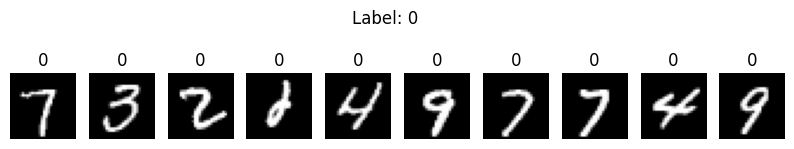

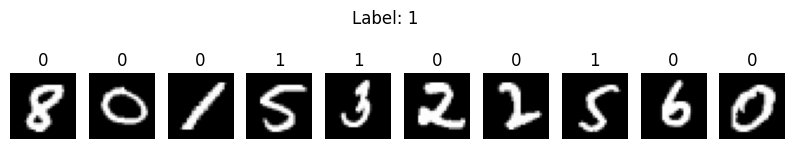

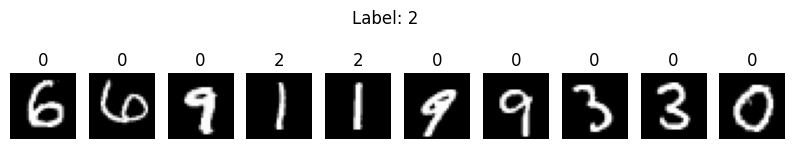

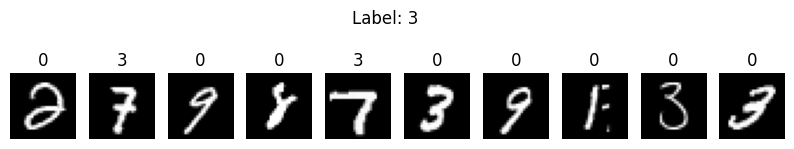

In [ ]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

class MNISTBagDataset(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform
        self.num_instances = len(mnist_dataset)

    def __len__(self):
        return self.num_instances

    def __getitem__(self, index):
        # Randomly create a bag of instances.
        bag_images = []
        bag_contains_1 = 0
        bag_contains_3 = 0
        bag_contains_5 = 0
        bag_contains_7 = 0

        # Randomly select a pair of image indices.
        instance_indices = torch.randint(0, self.num_instances, (10,))
        labels = []

        for idx in instance_indices:
            image, label = self.mnist_dataset[idx]

            labels.append(label)
            # Label the bag as Positive if it contains images with labels 1 or 3.
            if label == 1:
                bag_contains_1 += 1
            elif label == 3:
                bag_contains_3 += 1
            elif label == 5:
                bag_contains_5 += 1
            elif label == 7:
                bag_contains_7 += 1

            if self.transform:
                image = self.transform(image)

            bag_images.append(image)

        bag_images = torch.stack(bag_images)

        if (bag_contains_3 > 0) and (bag_contains_5 > 0):
            if bag_contains_7 == 0 and (bag_contains_1 > bag_contains_3):
                bag_label = torch.tensor([2], dtype=torch.float32)

            if bag_contains_1 > 0 and (bag_contains_7 > bag_contains_3):
                bag_label = torch.tensor([3], dtype=torch.float32)

            else:
                bag_label = torch.tensor([1], dtype=torch.float32)

        elif (bag_contains_7 != 0) and (bag_contains_1 > 0):
            bag_label = torch.tensor([3], dtype=torch.float32)

        elif bag_contains_1 > 0:
            bag_label = torch.tensor([2], dtype=torch.float32)

        else:
            bag_label = torch.tensor([0], dtype=torch.float32)

        labels = torch.tensor(labels)
        labels2 = torch.zeros(labels.shape).int()
        labels3 = torch.zeros(labels.shape).int()

        # if bag_label == 0:
        #     labels[:] = 0
        labels3[labels==3] = 1
        labels3[labels==5] = 1
        labels3[labels==1] = 2
        labels3[labels==7] = 3

        if bag_label == 1:
            labels2[labels==3] = 1
            labels2[labels==5] = 1


        elif bag_label == 2:
            labels2[labels==1] = 2

        elif bag_label == 3:
            labels2[labels==7] = 3

        return bag_images, bag_label, labels2  #, labels3

# Import the MNIST dataset.
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

# Determine the size of the entire dataset.
dataset_size = len(mnist_train)

# Calculate the size to split into Train and Test datasets.
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Create indices to split the dataset.
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Split indices into Train and Test datasets.
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use the Subset class to create Train and Test datasets.
train_dataset = Subset(mnist_train, train_indices)
test_dataset = Subset(mnist_train, test_indices)

# Create a MIL-style dataset.
train_dataset = MNISTBagDataset(train_dataset, transform=None)
test_dataset = MNISTBagDataset(test_dataset, transform=None)

# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def show_images(images, label, labels2):
    # Create a canvas to draw images on.
    fig = plt.figure(figsize=(10, 2))
    # plt.title("Label: "+str(label))
    for idx in range(len(images)):
        ax = fig.add_subplot(1, len(images), idx + 1)
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(str(labels2[idx].detach().numpy()))
        ax.axis('off')
    fig.suptitle("Label: "+str(label))
    plt.show()

# Check the dataset
for bags, labels1, labels2 in train_loader:
    print('Bag shapes:', bags.shape)
    print('Bag labels:', labels1.shape)
    print('Bag labels:', labels2.shape)
    break

for i in range(4):
    for j in range(len(bags)):
        if i == int(labels1[j].detach().cpu().numpy()[0]):
            show_images(bags[j], int(labels1[j].detach().cpu().numpy()[0]), labels2[j])
            break


# Models

In [ ]:
# Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return x

class AttentionMIL(torch.nn.Module):
    def __init__(self):
        super(AttentionMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x, tau=1.):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A/tau, dim=1)  # softmax over K
        features = A*features
        features = features.mean(1)

        return self.classifier(features), A.reshape(x.shape[0], 10)

class AdditiveMIL(torch.nn.Module):
    def __init__(self):
        super(AdditiveMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x, tau=1.):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A/tau, dim=1)  # softmax over K
        features = A*features
        predicts = self.classifier(features)

        return torch.functional.F.log_softmax(torch.sum(predicts, 1), dim=1), predicts, A.reshape(x.shape[0], 10)

class ConjunctiveMIL(torch.nn.Module):
    def __init__(self):
        super(ConjunctiveMIL, self).__init__()
        self.encoder = Encoder()

        self.attention_V = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix V
            torch.nn.Tanh()
        )

        self.attention_U = torch.nn.Sequential(
            torch.nn.Linear(128, 256), # matrix U
            torch.nn.Sigmoid()
        )

        self.attention_w = torch.nn.Linear(256, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.LayerNorm(64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 4),
            torch.nn.LogSoftmax(-1)
        )

    def forward(self, x, tau=1.):
        features = []
        for i in range(10):
            features.append(self.encoder(x[:, i]).reshape(x.shape[0], 1, -1))
        features = torch.concat(features, 1)

        A_V = self.attention_V(features)  # KxL
        A_U = self.attention_U(features)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.nn.functional.softmax(A/tau, dim=1)  # softmax over K
        predicts = A*self.classifier(features)
        return torch.functional.F.log_softmax(torch.sum(predicts, 1), dim=1), predicts, A.reshape(x.shape[0], 10)

# Test

In [ ]:
f1s = []
rocs = []

# Adjusting attention distribution
for t in [i for i in np.arange(0.5, 1, 0.1)] + [i for i in np.arange(1, 6, 1)]:
    print(t)
    print(t)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize the model
    model = ConjunctiveMIL().to(device)

    # Set the loss function and optimization algorithm
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    model.train()
    for epoch in tqdm_notebook(range(20)):
        train_pred, train_label = [], []
        for data in tqdm_notebook(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(inputs, tau=t)
            loss = criterion(outputs, labels.reshape(-1).long())
            loss.backward()
            optimizer.step()
            train_pred += list(outputs.detach().cpu().numpy())
            train_label += list(labels.detach().cpu().numpy())
        train_pred = np.array(train_pred)
        train_label = np.array(train_label)

        print(f'Epoch: {epoch}')
        print(f'acc Score: {accuracy_score(train_label, train_pred.argmax(1))}')
        print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="macro")}')
        print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="micro")}')
        print(f'F1 Score: {f1_score(train_label, train_pred.argmax(1), average="weighted")}')
        # print(f'ROC AUC Score: {roc_auc_score(train_label, train_pred[:, 1] - train_pred[:, 0])}')

    model.eval()
    test_pred, test_label = [], []
    test_pred2, test_label2 = [], []
    atts = []
    for data in tqdm_notebook(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels2 = data[2].to(device)
        outputs, outputs2, att = model(inputs, tau=t)
        test_pred += list(outputs.detach().cpu().numpy())
        test_label += list(labels.detach().cpu().numpy())

        test_pred2 += list(outputs2.detach().cpu().numpy())
        test_label2 += list(labels2.detach().cpu().numpy())
        atts += list(att.detach().cpu().numpy())

    test_pred = np.array(test_pred)
    test_label = np.array(test_label)

    test_pred2 = np.array(test_pred2)
    test_label2 = np.array(test_label2)

    atts = np.array(atts).reshape(-1)
    print(f'att_mean: {np.mean(atts)}, att_var: {np.var(atts)}')

    print('bag')
    print(f'acc Score: {accuracy_score(test_label, test_pred.argmax(1))}')
    print(f'macro f1: {f1_score(test_label, test_pred.argmax(1), average="macro")}')
    print(f'micro f1: {f1_score(test_label, test_pred.argmax(1), average="micro")}')
    print(f'weighted f1: {f1_score(test_label, test_pred.argmax(1), average="weighted")}')

    print('instance')
    print(f'macro f1: {f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="macro")}')
    print(f'micro f1: {f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="micro")}')
    print(f'weighted f1: {f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="weighted")}')

    f1s.append(
        [
            f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="macro"),
            f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="micro"),
            f1_score(test_label2.reshape(-1), test_pred2.reshape(-1, 4).argmax(1), average="weighted")
        ]
    )

    print(f'roc auc score1: {roc_auc_score(test_label2.reshape(-1) == 1, test_pred2.reshape(-1, 4)[:, 1])}')
    print(f'roc auc score2: {roc_auc_score(test_label2.reshape(-1) == 2, test_pred2.reshape(-1, 4)[:, 2])}')
    print(f'roc auc score3: {roc_auc_score(test_label2.reshape(-1) == 3, test_pred2.reshape(-1, 4)[:, 3])}')

    rocs.append(
        [
            roc_auc_score(test_label2.reshape(-1) == 1, test_pred2.reshape(-1, 4)[:, 1]),
            roc_auc_score(test_label2.reshape(-1) == 2, test_pred2.reshape(-1, 4)[:, 2]),
            roc_auc_score(test_label2.reshape(-1) == 3, test_pred2.reshape(-1, 4)[:, 3])
        ]
    )
